In [487]:
# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
# NOTE: PANDAS DATAFRAMES ALIGN WITH MATHEMATICAL INDEXING CONVENTION FOR MATRICES BY USING df.iloc
np.random.seed(10)

In [488]:
industry_demand = dict()
x = dict()
input_constrained_x = dict()
labour_constrained_x = dict()
Z = dict()
industry_orders = dict()

S = dict()
demand_non_household_final_demand = dict()
demand_household_consumption = dict()

industry_labour_comp = dict()
industry_change_in_labour_compensation = dict()
industry_outlooks = dict()
non_household_final_demand = dict()
household_consumption = dict()

In [489]:
def sigmoid(x, k=1): # setting k from 50 to 1
    """
    Calculate the sigmoid function.
    
    Parameters:
    x (float): The input value to the sigmoid function.
    k (float): The steepness of the sigmoid curve.
    
    Returns:
    float: The output of the sigmoid function.
    """
    return 1 / (1 + np.exp(-k * x))

In [490]:
with open('industry_outputs_300.json', 'r') as f:
    x[0] = np.array(json.load(f))

with open('input_constrained_outputs_299.json', 'r') as f:
    input_constrained_x[0] = np.array(json.load(f))

with open('input_constrained_outputs_300.json', 'r') as f:
    input_constrained_x[1] = np.array(json.load(f))

with open('labour_constrained_outputs_299.json', 'r') as f:
    labour_constrained_x[0] = np.array(json.load(f))

with open('labour_constrained_outputs_300.json', 'r') as f:
    labour_constrained_x[1] = np.array(json.load(f))

with open('industry_demand_299.json', 'r') as f:
    industry_demand[0] = np.array(json.load(f))

with open('industry_demand_300.json', 'r') as f:
    industry_demand[1] = np.array(json.load(f))

with open('intermediate_consumption.json', 'r') as f:
    Z[0] = np.array(json.load(f))

with open('industry_orders.json', 'r') as f:
    industry_orders[0] = np.array(json.load(f))

with open('inventories_299.json', 'r') as f:
    S[0] = np.array(json.load(f))

with open('inventories_300.json', 'r') as f:
    S[1] = np.array(json.load(f))

with open('target_inventories.json', 'r') as f:
    target_inventory = np.array(json.load(f))

with open('non_household_final_demand.json', 'r') as file:
    demand_non_household_final_demand[0] = np.array(json.load(file))

with open('demand_household_consumption.json', 'r') as f:
    demand_household_consumption[0] = np.array(json.load(f))

with open('industry_labour_comp_299.json', 'r') as f:
    industry_labour_comp[0] = np.array(json.load(f))

industry_outlooks[0] = np.array([0.5, 0.5, 0.5])

In [491]:
with open('constants.json', 'r') as f:
    loaded_constants = json.load(f)

inventory_adjustment = loaded_constants['inventory_adjustment']
downward_labour_adjustment = loaded_constants['downward_labour_adjustment']
upward_labour_adjustment = loaded_constants['upward_labour_adjustment']
consumption_adjustment = loaded_constants['consumption_adjustment']
initial_total_labour_compensation = loaded_constants['initial_total_labour_compensation']
total_labour_compensation = loaded_constants['total_labour_compensation']
total_permanent_labour_compensation = loaded_constants['total_permanent_labour_compensation']
Labour_share = np.array(loaded_constants['Labour_share'])
initial_labour_constrained_outputs = np.array(loaded_constants['initial_labour_constrained_outputs'])

with open('full_capacity_production_level.json') as f:
    full_capacity_production_levels = json.load(f)

num_industries = x[0].shape[0]

IO_matrix = np.array(loaded_constants['IO_matrix'])
initial_industry_labour_comp = np.array(loaded_constants['initial_industry_labour_comp'])

In [492]:
# # ORIGINAL MODEL

memory = np.zeros(num_industries)
def run_model(days, shock_magnitude): #days = Max Iterations
    t = 1
    while t < days:
        
        # -------------- STEP 1 - Calculate new labour compensation for each INDUSTRY --------------
        current_change_in_labour_compensation = np.array([
            np.multiply(Labour_share[i], np.minimum(input_constrained_x[t - 1][i], industry_demand[t][i]) - labour_constrained_x[t - 1][i])
            for i in range(num_industries)
        ])

        industry_change_in_labour_compensation[t] = current_change_in_labour_compensation
        
        current_industry_labour_compensation = np.zeros(num_industries)
        
        for i in range(num_industries):
            if (industry_change_in_labour_compensation[t][i] >= 0):
                current_labour_compensation = industry_labour_comp[t - 1][i] + np.multiply(upward_labour_adjustment, industry_change_in_labour_compensation[t][i])
            if (industry_change_in_labour_compensation[t][i] < 0):
                current_labour_compensation = industry_labour_comp[t - 1][i] + np.multiply(downward_labour_adjustment, industry_change_in_labour_compensation[t][i])
                
            current_industry_labour_compensation[i] = current_labour_compensation

        industry_labour_comp[t] = current_industry_labour_compensation
        
        
        # -------------- STEP 2 - Calculating O_{ij, t} meaning the amount of good i ordered (not yet fulfilled, just ordered) by industry j (i -> j) --------------
        industry_demand_column = industry_demand[t - 1].reshape(-1, 1) if industry_demand[t-1].ndim == 1 else industry_demand[t-1]
        industry_orders[t] = np.maximum(0, np.multiply(IO_matrix, industry_demand_column.T) + np.multiply(np.divide(1, inventory_adjustment), target_inventory - S[t]))
        
        
        
        # -------------- STEP 3.1 - Calculate Labour Constrained Output in current time step for each INDUSTRY --------------
        labour_constrained_x[t] = np.multiply(np.divide(industry_labour_comp[t], initial_industry_labour_comp), initial_labour_constrained_outputs)

        # -------------- STEP 3.2 - Calculate Intermediate Input Constrained Output in current time step for each INDUSTRY --------------
        bottlenecks = np.divide(S[t].T, IO_matrix.T) # S_{ji, t} / A_{ji}
        input_constrained_x[t] = np.min(bottlenecks, axis=0)

        
        # -------------- STEP 3.3 - Calculate Output based on minimum of both constrained outputs and current industry demand in current time step for each INDUSTRY --------------
        combined_constrained_outputs = np.array([labour_constrained_x[t], input_constrained_x[t], industry_demand[t]])
        x_t = np.minimum.reduce(combined_constrained_outputs, axis=0)
        x_t[x_t <= 0] = 0
        x[t] = x_t
        
        # -------------- STEP 4 - Calculate delivery of goods from industry i to industry j for every INDUSTRY based on orders from step 2 and current industry outlooks --------------
        
        ratio = np.divide(x[t], industry_demand[t], out=np.zeros_like(x[t], dtype=float), where=industry_demand[t]!=0)
        
        industry_outlooks[t] = np.zeros(num_industries)
        for i in range(num_industries):
            # Integrate using the trapezoidal rule, with a step size of 1
            
            I_t = sigmoid(np.divide(np.sum(x[t]) - x[t][i], np.sum(full_capacity_production_levels) - full_capacity_production_levels[i]))
            
            if t > 1:  # Need at least two data points to start integrating
                memory[i] += 0.5 * ((I_t - industry_outlooks[t-1][i]) + (industry_outlooks[t-1][i] - industry_outlooks[t-2][i]))
            
            # k * (outlook calculation - outlook in previous time step) + h * memory
            
            outlook_rate_of_change = 3 * (I_t - industry_outlooks[t-1][i]) + 12 * memory[i]
            new_outlook = industry_outlooks[t-1][i] + outlook_rate_of_change
        
            # new_outlook = min(max(new_outlook, 0), 1)
            
            new_outlook= sigmoid(new_outlook)
            
            industry_outlooks[t][i] = new_outlook
        
        
        
        
        
        
        # Note: we multiply by current_industry_outlooks to indicate how much each industry that ordered is ACTUALLY getting due to industry outlook
        # The corresponding proportion of each order is instead fulfilled due to industry outlook
        
        # current_outlook = alpha * current_outlooks + (1 - alpha) * industry_outlooks[t - 1]
        
        
        
        
        Z_t = (industry_orders[t] * ratio[:, np.newaxis]) * industry_outlooks[t]
        # If industry_orders[t] is a DataFrame, you can convert Z_t back to a DataFrame
        # Z_t = pd.DataFrame(Z_t, index=industry_orders[t].aindex, columns=industry_orders[t].columns)
        # Z.append(Z_t)
        
        Z[t] = np.maximum(0, Z_t)

        # -------------- STEP 5.1 - Calculate (demand) non household final demand (currently kept constant f^d_{t} = f^d_{0} FOR NOW ) --------------
        demand_non_household_final_demand[t] = demand_non_household_final_demand[0]
        non_household_final_demand[t] = np.multiply(demand_non_household_final_demand[t], np.divide(x[t],industry_demand[t], out=np.zeros_like(x[t], dtype=float), where=industry_demand[t]!=0))
        
        m = 0.82 # Using same m value from Pichler's paper
        exogenous_consumption_demand_shock = shock_magnitude 
        

        # TODO: 
        # Keep it as is now, 
        # Discuss with Paolo on the possibility of modelling permanent labour income expecation 
        # through moving average and the implications of it 

        # Muellbrauer's interpretation on how household consumption evolves through an autoregressive process with my incorporation of change in savings rate 
        # This allows us to see how the model evolves under different consumer saving behaviours (whether households choose to SAVE OR SPEND more of their income)

        # -------------- STEP 5.2 - Calculate (demand) household consumption (using autoregressive process suggested by Muellbrauer) --------------
        
        if t == 500: # negative shock
            demand_household_consumption[t] = demand_household_consumption[t - 1] * (1 - exogenous_consumption_demand_shock)
        elif t == 600: # postive shock
            demand_household_consumption[t] = demand_household_consumption[0]
        else:
            demand_household_consumption[t] = demand_household_consumption[t - 1]
        
        # demand_household_consumption[t] = demand_household_consumption[t - 1]
        
        # household_consumption[t] = np.float128(np.multiply(demand_household_consumption[t], np.divide(x[t],industry_demand[t], out=np.zeros_like(x[t], dtype=float), where=industry_demand[t]!=0)))
        household_consumption[t] = np.multiply(demand_household_consumption[t], np.divide(x[t],industry_demand[t], out=np.zeros_like(x[t], dtype=float), where=industry_demand[t]!=0))

        # -------------- STEP 5.3 - Calculate industry demand for next time step, for EVERY INDUSTRY --------------
        
        inventory_orders_row_sum = industry_orders[t].sum(axis=1)
        
        # next_industry_demand = np.maximum(0, (industry_outlooks[t] * inventory_orders_row_sum) + demand_non_household_final_demand[t] + demand_household_consumption[t])
        next_industry_demand = np.maximum(0, (inventory_orders_row_sum) + demand_non_household_final_demand[t] + demand_household_consumption[t])

        # print("updating industry demand at time: " + str(t+1))
        industry_demand[t+1] = next_industry_demand
        

        # -------------- STEP 6 - Calculate inventory levels for next time step, for every INDUSTRY --------------
        
        
        # x_column = x[t].values.reshape(-1, 1) if x[t].ndim == 1 else x[t].values
        # updated_inventory_levels = np.maximum(S[t].values + Z[t].values - np.multiply(IO_matrix.values, x_column.T), 0)
        
        x_column = x[t].reshape(-1, 1) if x[t].ndim == 1 else x[t]

        # Calculate updated inventory levels using element-wise operations
        updated_inventory_levels = np.maximum(S[t] + Z[t] - np.multiply(IO_matrix, x_column.T), 0)
        
        # S.append(pd.DataFrame(updated_inventory_levels))
        
        S[t+1] = updated_inventory_levels
        
        # Now proceeding to next day of simulation
        
        
        t += 1
        
    
    return x
    

def plot_results(days, x, x_mean, x_sigma, Z_mean, Z_sigma, industry_labour_comp_mean, industry_labour_comp_sigma, industry_demand_mean, industry_demand_sigma, demand_non_household_final_demand_mean, demand_non_household_final_demand_sigma, demand_household_consumption_mean, demand_household_consumption_sigma):
    for industry in range(3):
        df_x = pd.DataFrame(x)

        df_x = df_x.T

        x_1 = df_x.iloc[:, industry]
        y_values = list(range(days))

        plt.plot(y_values, x_1, marker='.')
        plt.title('Industry Output (industry ' + str(industry) + ') over time in dynamic IO model')
        plt.xlabel('Time (Days)')
        plt.ylabel('Industry Output (Monetary Value)')

        plt.grid(True)

        plt.show()

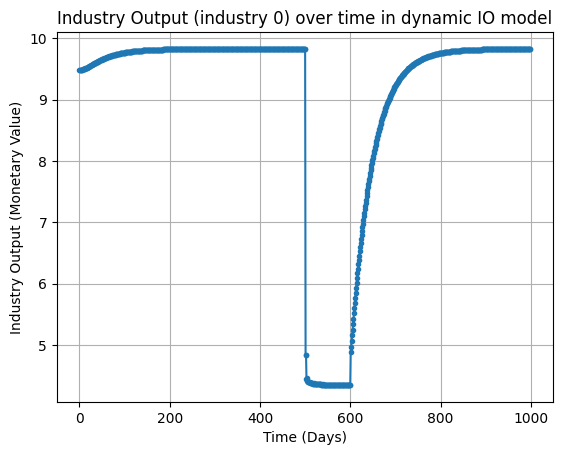

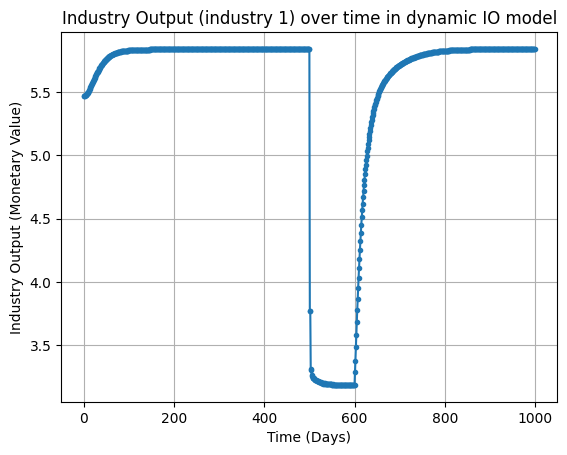

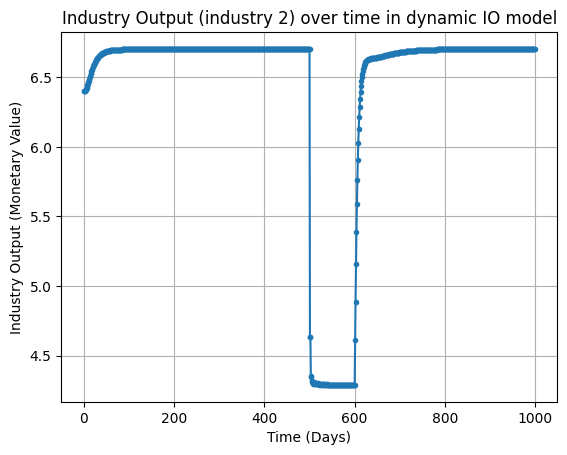

{0: array([9.4893266 , 5.47282327, 6.40226566]),
 1: array([9.4893266 , 5.47282327, 6.40226566]),
 2: array([9.4893266 , 5.47282327, 6.40226566]),
 3: array([9.48989593, 5.47376387, 6.40485248]),
 4: array([9.49042677, 5.47506459, 6.40813894]),
 5: array([9.49123581, 5.47702034, 6.41289988]),
 6: array([9.49252975, 5.48013282, 6.42033672]),
 7: array([9.49438631, 5.48456364, 6.43064492]),
 8: array([9.49659577, 5.48976287, 6.44204557]),
 9: array([9.4989687 , 5.49525218, 6.45312849]),
 10: array([9.5014993 , 5.50101998, 6.46390572]),
 11: array([9.50430575, 5.50735498, 6.47523551]),
 12: array([9.50744521, 5.5143834 , 6.48746009]),
 13: array([9.51081028, 5.52182294, 6.49976011]),
 14: array([9.5142719 , 5.52934927, 6.51127045]),
 15: array([9.51780958, 5.53691533, 6.52197333]),
 16: array([9.52148934, 5.54468561, 6.53244487]),
 17: array([9.52535205, 5.55275535, 6.54301868]),
 18: array([9.52934343, 5.56098249, 6.55333454]),
 19: array([9.53338192, 5.56916368, 6.56288894]),
 20: array

In [493]:
x = run_model(days=1000, shock_magnitude=0.9)    
plot_results(days=1000, x=x, x_mean=3, x_sigma=1, Z_mean=2.7, Z_sigma=1, industry_labour_comp_mean=1.0, industry_labour_comp_sigma=0.3, industry_demand_mean=2.8, industry_demand_sigma=1, demand_non_household_final_demand_mean=0.9, demand_non_household_final_demand_sigma=0.5, demand_household_consumption_mean=0.95, demand_household_consumption_sigma=0.5)

x

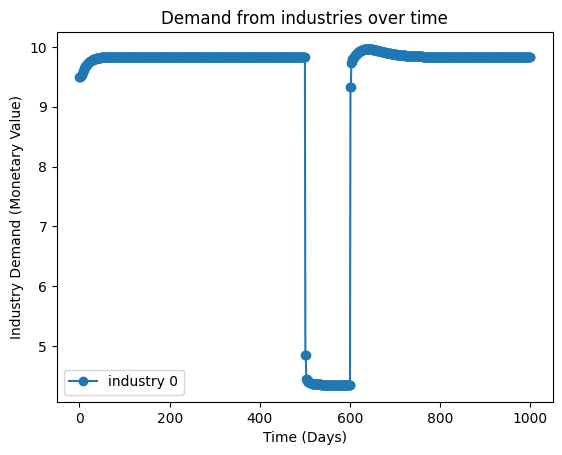

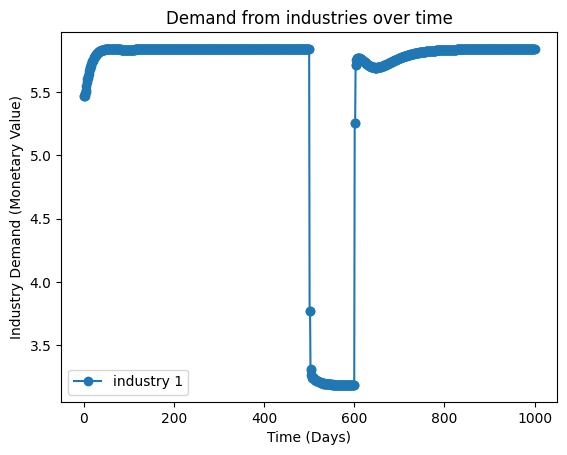

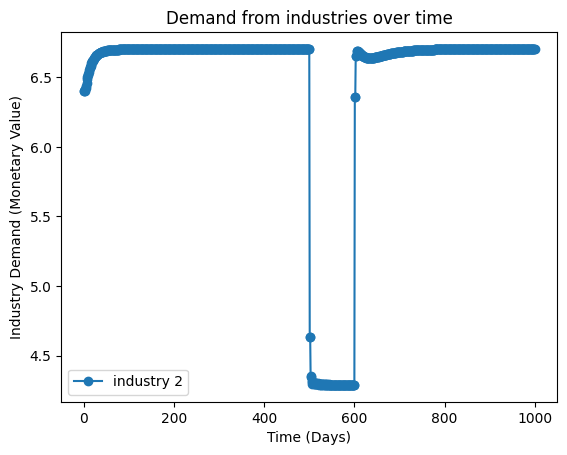

{0: [9.489326602229543,
  9.489326602229543,
  9.489326602229543,
  9.508326072350762,
  9.516437711511006,
  9.53087900421999,
  9.55593281768529,
  9.585357842688865,
  9.604859035689671,
  9.615242098221142,
  9.625498740963632,
  9.641821830901044,
  9.661278734004078,
  9.67569902003925,
  9.683891359897153,
  9.691155755047248,
  9.70179736623258,
  9.714624875146338,
  9.724921311070998,
  9.731267618157847,
  9.736528485030991,
  9.743552410276424,
  9.7519992448516,
  9.759215112756674,
  9.764023747974894,
  9.767871391301407,
  9.77255663851455,
  9.778116876325859,
  9.783103176455256,
  9.786663393309823,
  9.789475155202227,
  9.792627994115659,
  9.79628871912432,
  9.799693749314475,
  9.80227145220227,
  9.804309028250657,
  9.806442499727417,
  9.808851978186453,
  9.811151855779542,
  9.812978881006075,
  9.814435384053603,
  9.815880277485153,
  9.817462853287328,
  9.818998664597213,
  9.820266656173612,
  9.821289341027246,
  9.822262834699828,
  9.823296352639371

In [494]:
industry_demands = {}
for i in range(num_industries):
    industry_demands[i] = []

for time, demand in industry_demand.items():
    for j in range(num_industries):
        industry_demands[j].append(demand[j])

for j in range(num_industries):
    plt.plot(np.arange(len(industry_demands[j])), industry_demands[j], marker='o', label = 'industry {}'.format(str(j)))
    plt.title('Demand from industries over time')
    plt.xlabel('Time (Days)')
    plt.ylabel('Industry Demand (Monetary Value)')
    plt.legend()
    plt.show()

industry_demands

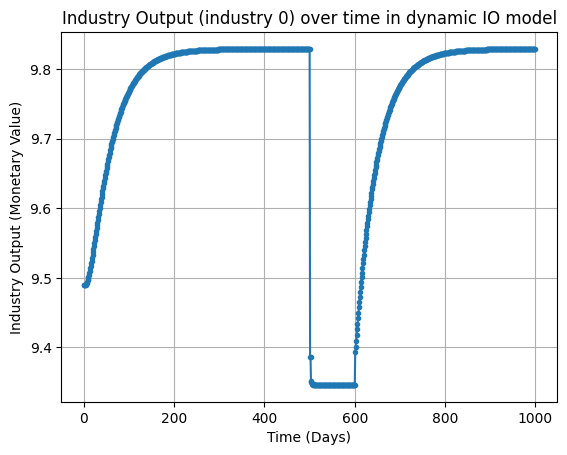

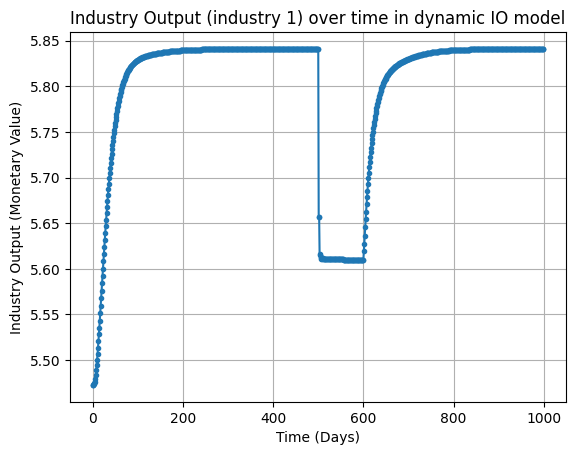

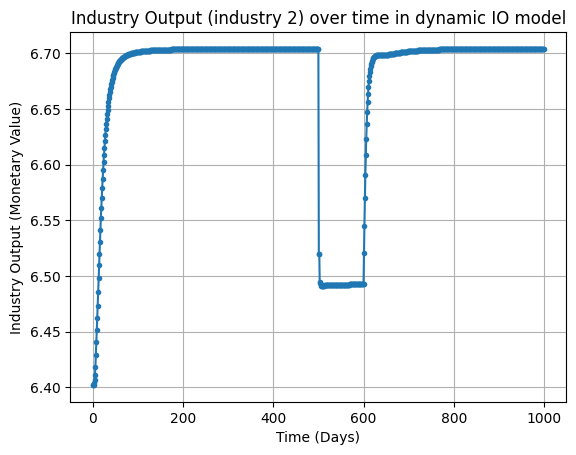

{0: array([9.4893266 , 5.47282327, 6.40226566]),
 1: array([9.4893266 , 5.47282327, 6.40226566]),
 2: array([9.4893266 , 5.47282327, 6.40226566]),
 3: array([9.4898231 , 5.47358359, 6.40435672]),
 4: array([9.49025959, 5.47465515, 6.40706836]),
 5: array([9.49098582, 5.47641667, 6.41140391]),
 6: array([9.49223894, 5.47944311, 6.41875311]),
 7: array([9.49407146, 5.48383014, 6.42909657]),
 8: array([9.49623646, 5.48893475, 6.4403887 ]),
 9: array([9.49855047, 5.49429569, 6.45127743]),
 10: array([9.5010289 , 5.49995499, 6.46192763]),
 11: array([9.50380674, 5.50624194, 6.47330257]),
 12: array([9.50693081, 5.51325523, 6.4856524 ]),
 13: array([9.51027218, 5.52065867, 6.49800189]),
 14: array([9.5137004 , 5.52812564, 6.50948623]),
 15: array([9.5172076 , 5.5356411 , 6.52018258]),
 16: array([9.52087054, 5.54339559, 6.53073753]),
 17: array([9.52472579, 5.55147252, 6.54144416]),
 18: array([9.52870662, 5.5596985 , 6.55185135]),
 19: array([9.53272851, 5.56786346, 6.56144107]),
 20: array

In [495]:
x = run_model(days=1000, shock_magnitude=0.08)    
plot_results(days=1000, x=x, x_mean=3, x_sigma=1, Z_mean=2.7, Z_sigma=1, industry_labour_comp_mean=1.0, industry_labour_comp_sigma=0.3, industry_demand_mean=2.8, industry_demand_sigma=1, demand_non_household_final_demand_mean=0.9, demand_non_household_final_demand_sigma=0.5, demand_household_consumption_mean=0.95, demand_household_consumption_sigma=0.5)

x

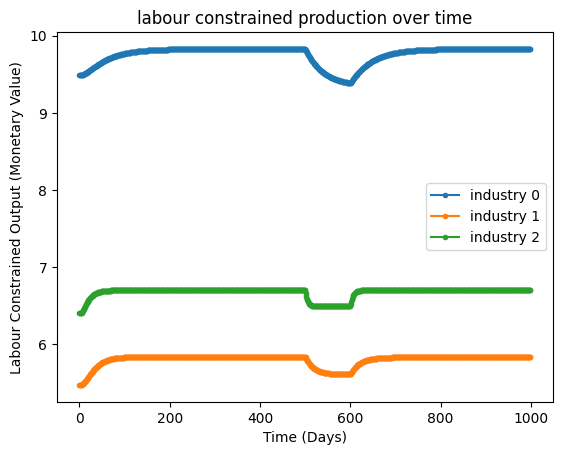

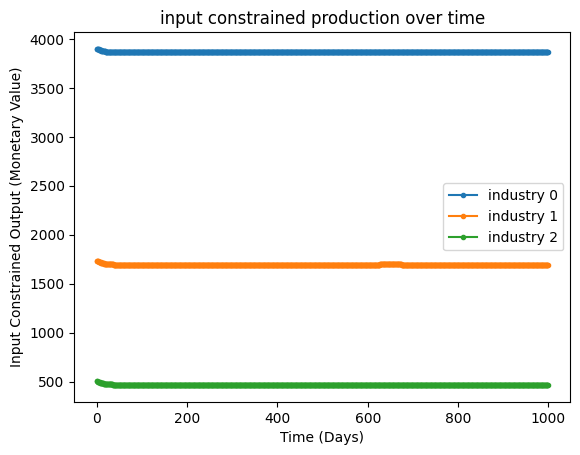

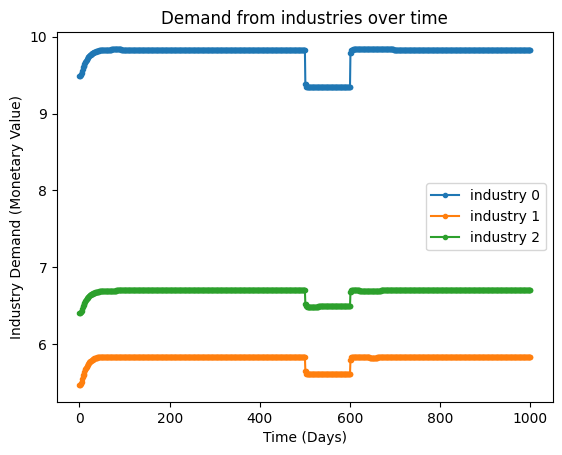

({0: array([9.48952984, 5.47282327, 6.40226566]),
  1: array([9.48952476, 5.47282327, 6.40226566]),
  2: array([9.48951981, 5.47282327, 6.40226566]),
  3: array([9.4898231 , 5.47358359, 6.40435672]),
  4: array([9.49025959, 5.47465515, 6.40706836]),
  5: array([9.49098582, 5.47641667, 6.41140391]),
  6: array([9.49223894, 5.47944311, 6.41875311]),
  7: array([9.49407146, 5.48383014, 6.42909657]),
  8: array([9.49623646, 5.48893475, 6.4403887 ]),
  9: array([9.49855047, 5.49429569, 6.45127743]),
  10: array([9.5010289 , 5.49995499, 6.46192763]),
  11: array([9.50380674, 5.50624194, 6.47330257]),
  12: array([9.50693081, 5.51325523, 6.4856524 ]),
  13: array([9.51027218, 5.52065867, 6.49800189]),
  14: array([9.5137004 , 5.52812564, 6.50948623]),
  15: array([9.5172076 , 5.5356411 , 6.52018258]),
  16: array([9.52087054, 5.54339559, 6.53073753]),
  17: array([9.52472579, 5.55147252, 6.54144416]),
  18: array([9.52870662, 5.5596985 , 6.55185135]),
  19: array([9.53272851, 5.56786346, 6.56

In [496]:
labour_constrained_productions = {}
input_constrained_productions = {}

for i in range(num_industries):
    labour_constrained_productions[i] = []
    input_constrained_productions[i] = []
    

time_axis = np.arange(start = 0, stop=1000, step=1)

for time, labour_constrained_production in labour_constrained_x.items():
    for i in range(num_industries):
        labour_constrained_productions[i].append(labour_constrained_production[i])

for time, input_constrained_production in input_constrained_x.items():
    for i in range(num_industries):
        input_constrained_productions[i].append(input_constrained_production[i])
        
for j in range(num_industries):
    plt.plot(time_axis, labour_constrained_productions[j], marker='.', label='industry {}'.format(str(j)))

plt.title('labour constrained production over time')
plt.xlabel('Time (Days)')
plt.ylabel('Labour Constrained Output (Monetary Value)')
plt.legend()
plt.show()

for j in range(num_industries):
    plt.plot(time_axis, input_constrained_productions[j], marker='.', label='industry {}'.format(str(j)))

plt.title('input constrained production over time')
plt.xlabel('Time (Days)')
plt.ylabel('Input Constrained Output (Monetary Value)')
plt.legend()

plt.show()

# Orders from industry 0 to industry 1 and 2 are very high j which must be due to industry demand of industry 1 and 2
industry_demands = {}
for i in range(num_industries):
    industry_demands[i] = []

for time, demand in industry_demand.items():
    for j in range(num_industries):
        industry_demands[j].append(demand[j])

for j in range(num_industries):
    plt.plot(np.arange(len(industry_demands[j])), industry_demands[j], marker='.', label = 'industry {}'.format(str(j)))

plt.title('Demand from industries over time')
plt.xlabel('Time (Days)')
plt.ylabel('Industry Demand (Monetary Value)')
plt.legend()
plt.show()

labour_constrained_x, input_constrained_x

In [497]:
for i in range(num_industries):
    industry_demands[i].pop()

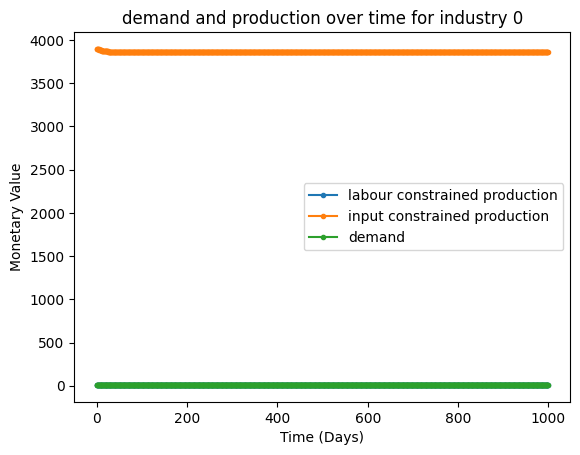

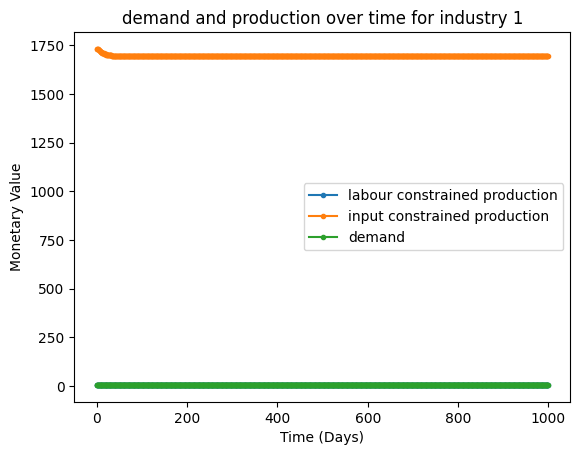

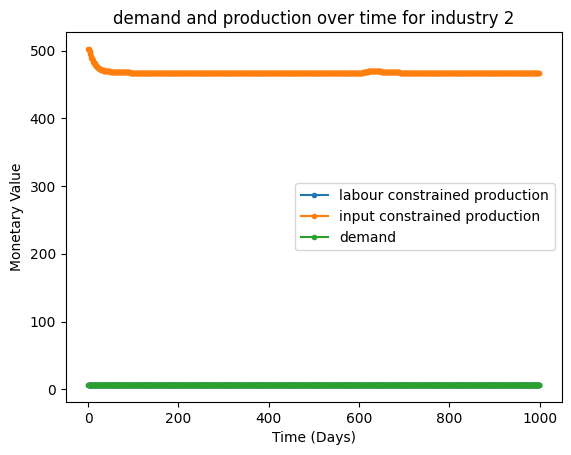

In [498]:
for j in range(num_industries):
    plt.plot(time_axis, labour_constrained_productions[j], marker='.', label='labour constrained production')
    plt.plot(time_axis, input_constrained_productions[j], marker='.', label='input constrained production')
    plt.plot(time_axis, industry_demands[j], marker='.', label='demand')
    plt.title('demand and production over time for industry {}'.format(j))
    plt.xlabel('Time (Days)')
    plt.ylabel('Monetary Value')
    plt.legend()
    plt.show()



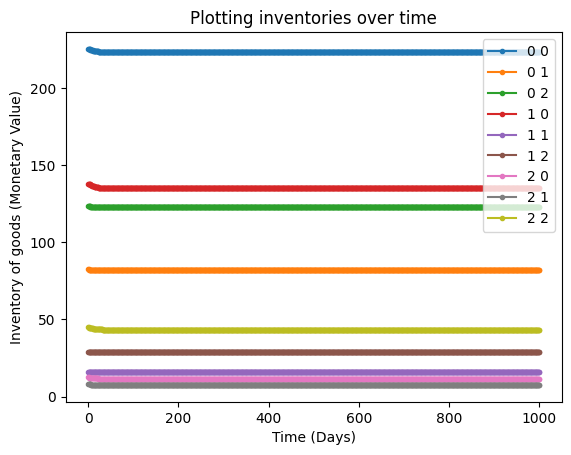

In [499]:
inventories = dict()

inventories['0 0'] = []
inventories['0 1'] = []
inventories['0 2'] = []
inventories['1 0'] = []
inventories['1 1'] = []
inventories['1 2'] = []
inventories['2 0'] = []
inventories['2 1'] = []
inventories['2 2'] = []

good_i_to_industry_j = ['0 0', '0 1', '0 2', '1 0', '1 1', '1 2', '2 0', '2 1', '2 2']

for time, inv in S.items():
    for inter_industries in good_i_to_industry_j:
        
        good_provider = int(inter_industries.split(' ')[0])
        good_receiver = int(inter_industries.split(' ')[1])
        # inventories[inter_industries] = []
        inventories[inter_industries].append(inv[good_provider][good_receiver]) 
    
time_axis = np.arange(start = 0, stop=1001, step=1)

for inter_industries in good_i_to_industry_j:
    plt.plot(time_axis, inventories[inter_industries], marker='.', label= inter_industries)
    plt.title('Plotting inventories over time')
    plt.xlabel('Time (Days)')
    plt.ylabel('Inventory of goods (Monetary Value)')

plt.legend()

plt.show()


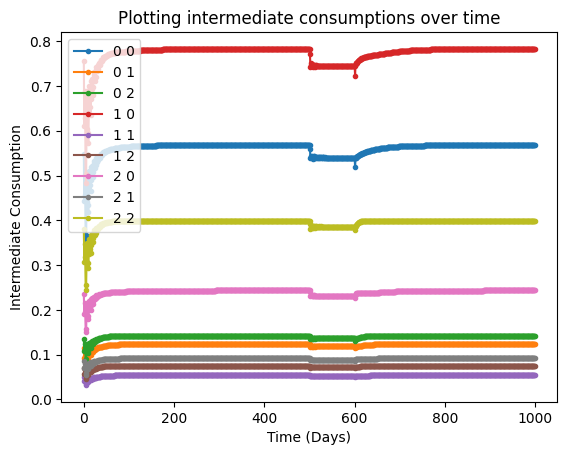

In [500]:
intermediate_consumptions = dict()

intermediate_consumptions['0 0'] = []
intermediate_consumptions['0 1'] = []
intermediate_consumptions['0 2'] = []
intermediate_consumptions['1 0'] = []
intermediate_consumptions['1 1'] = []
intermediate_consumptions['1 2'] = []
intermediate_consumptions['2 0'] = []
intermediate_consumptions['2 1'] = []
intermediate_consumptions['2 2'] = []

intermediate_consumptions_paths = ['0 0', '0 1', '0 2', '1 0', '1 1', '1 2', '2 0', '2 1', '2 2']

for time, inv in Z.items():
    for inter_industries in intermediate_consumptions_paths:
        good_provider = int(inter_industries.split(' ')[0])
        good_receiver = int(inter_industries.split(' ')[1])
        intermediate_consumptions[inter_industries].append(inv[good_provider][good_receiver])

time_axis = np.arange(start = 0, stop=1000, step=1)

for inter_industries in intermediate_consumptions_paths:
    plt.plot(time_axis, intermediate_consumptions[inter_industries], marker='.', label=inter_industries)
    plt.title('Plotting intermediate consumptions over time')
    plt.xlabel('Time (Days)')
    plt.ylabel('Intermediate Consumption')

plt.legend()

plt.show()

{0: array([[0.54834821, 0.115649  , 0.13497708],
        [0.75565939, 0.05050009, 0.07132129],
        [0.23489353, 0.08633333, 0.38075323]]),
 1: array([[0.54834821, 0.115649  , 0.13497708],
        [0.75565939, 0.05050009, 0.07132129],
        [0.23489353, 0.08633333, 0.38075323]]),
 2: array([[0.55890462, 0.11786147, 0.13756624],
        [0.7702068 , 0.0514662 , 0.07268939],
        [0.23941553, 0.08798496, 0.38805691]]),
 3: array([[0.56370978, 0.11885186, 0.13873366],
        [0.77682862, 0.05189868, 0.07330625],
        [0.24147389, 0.0887243 , 0.39135006]]),
 4: array([[0.57384542, 0.12110905, 0.14126438],
        [0.79088259, 0.05289012, 0.07465165],
        [0.24581978, 0.09041084, 0.39849561]]),
 5: array([[0.592438  , 0.12502461, 0.14582685],
        [0.81659425, 0.05460599, 0.07707097],
        [0.25378474, 0.09333405, 0.41136664]]),
 6: array([[0.61305503, 0.1294972 , 0.15096042],
        [0.84514292, 0.05656823, 0.0797965 ],
        [0.26261508, 0.09667242, 0.42584571]]),

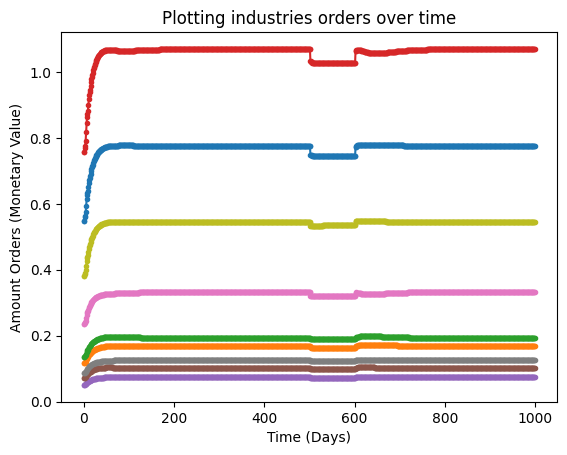

In [501]:
intermediate_orders = dict()

intermediate_orders['0 0'] = []
intermediate_orders['0 1'] = []
intermediate_orders['0 2'] = []
intermediate_orders['1 0'] = []
intermediate_orders['1 1'] = []
intermediate_orders['1 2'] = []
intermediate_orders['2 0'] = []
intermediate_orders['2 1'] = []
intermediate_orders['2 2'] = []

intermediate_orders_paths = ['0 0', '0 1', '0 2', '1 0', '1 1', '1 2', '2 0', '2 1', '2 2']


for time, inv in industry_orders.items():
    for inter_industries in intermediate_orders_paths:
        
        good_provider = int(inter_industries.split(' ')[0])
        good_receiver = int(inter_industries.split(' ')[1])
        
        intermediate_orders[inter_industries].append(inv[good_provider][good_receiver])

time_axis = np.arange(start = 0, stop=1000, step=1)

for inter_industries in intermediate_orders_paths:
    plt.plot(time_axis, intermediate_orders[inter_industries], marker='.', label=inter_industries)
    plt.title('Plotting industries orders over time')
    plt.xlabel('Time (Days)')
    plt.ylabel('Amount Orders (Monetary Value)')
    
# plt.plot(time_axis, intermediate_orders['0 2'], marker='o', label=inter_industries)
# plt.title('Plotting industries orders (0 -> 1) over time')
# plt.xlabel('Time (Days)')
# plt.ylabel('Amount Orders (Monetary Value)')

industry_orders


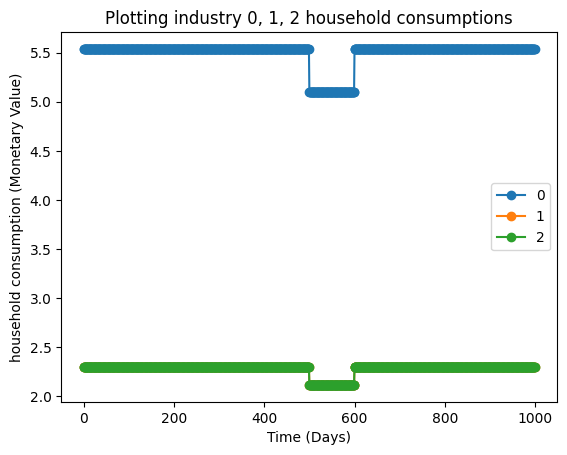

In [502]:

demand_non_household_final_demands = dict()

demand_non_household_final_demands[0] = []
demand_non_household_final_demands[1] = []
demand_non_household_final_demands[2] = []

demand_household_consumptions = dict()

demand_household_consumptions[0] = []
demand_household_consumptions[1] = []
demand_household_consumptions[2] = []


for time, f in demand_non_household_final_demand.items():
   demand_non_household_final_demands[0].append(f[0])
   demand_non_household_final_demands[1].append(f[1])
   demand_non_household_final_demands[2].append(f[2])
   
for time, c in demand_household_consumption.items():
   demand_household_consumptions[0].append(c[0])
   demand_household_consumptions[1].append(c[1])
   demand_household_consumptions[2].append(c[2])
   
# plt.plot(np.arange(start=0, stop=len(demand_household_consumption[0])), demand_non_household_final_demands[0], marker='.', label=0)
# plt.title('Plotting industry 0 final non household demands')
# plt.xlabel('Time (Days)')
# plt.ylabel('demand non household final demand (Monetary Value)')


for i in range(3):
   plt.plot(np.arange(start=0, stop=len(demand_household_consumptions[i])), demand_household_consumptions[i], marker='o', label=i)
   plt.title('Plotting industry 0, 1, 2 household consumptions')
   plt.xlabel('Time (Days)')
   plt.ylabel('household consumption (Monetary Value)')

plt.legend()
plt.show()

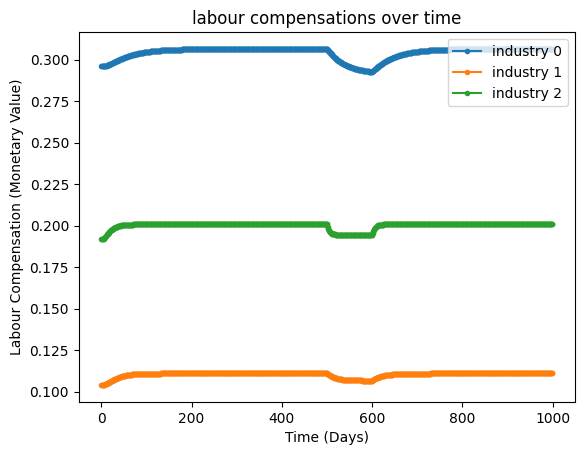

In [503]:
industry_labour_compensations = {}

for i in range(num_industries):
    industry_labour_compensations[i] = []
    
time_axis = np.arange(start = 0, stop=1000, step=1)

for time, industry_labour_compensation in industry_labour_comp.items():
    for i in range(num_industries):
        industry_labour_compensations[i].append(industry_labour_compensation[i])        

for j in range(num_industries):
    plt.plot(time_axis, industry_labour_compensations[j], marker='.', label='industry {}'.format(str(j)))


plt.title('labour compensations over time')
plt.xlabel('Time (Days)')
plt.ylabel('Labour Compensation (Monetary Value)')
plt.legend()
plt.show()

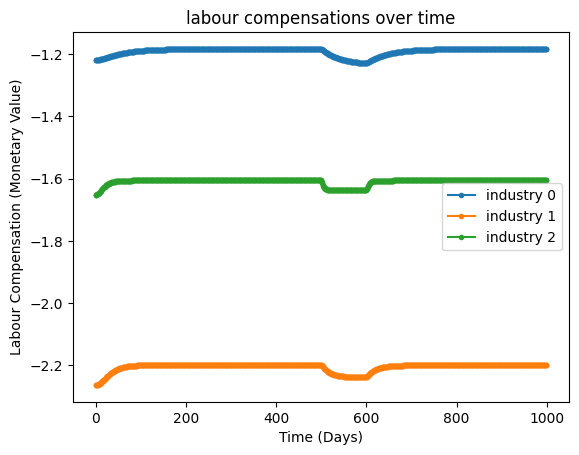

In [504]:
industry_labour_compensations = {}

for i in range(num_industries):
    industry_labour_compensations[i] = []
    
time_axis = np.arange(start = 0, stop=1000, step=1)

for time, industry_labour_compensation in industry_labour_comp.items():
    for i in range(num_industries):
        industry_labour_compensations[i].append(industry_labour_compensation[i])        

for j in range(num_industries):
    industry_labour_compensations[j] = np.log(industry_labour_compensations[j])

for j in range(num_industries):
    plt.plot(time_axis, industry_labour_compensations[j], marker='.', label='industry {}'.format(str(j)))

plt.title('labour compensations over time')
plt.xlabel('Time (Days)')
plt.ylabel('Labour Compensation (Monetary Value)')
plt.legend()
plt.show()

In [505]:
# TODO: Read literature about different shock values, test in a loop with different shock values
# TODO: Find recovery time to reach 50% and 90% of pre-shock output 
# TODO: calculate difference in output of each industry at pre-shock stabilisation and post-shock stabilisation

# TODO: After doing the above three, investigating how labour dynamics play into the gradual smooth economic recovery
# TODO: Investigate industry outlooks' ( and the sigmoid function as a consequence) role in recovery time if any

# TODO: Possibly try implementing other constraints to enforce hysteresis... (do this another file to not mess up results)

In [506]:
def get_recovery_times(x):
    pre_shock_output = x[500]
    post_shock_output = x[600]

    fifty_percent_recovery_outputs = post_shock_output + 0.5 * (pre_shock_output - post_shock_output)
    ninety_percent_recovery_outputs = post_shock_output + 0.9 * (pre_shock_output - post_shock_output)

    fifty_percent_recovery_times = dict()
    ninety_percent_recovery_times = dict()

    for industry in range(num_industries):
        
        for day in range(601, 1000):
            if x[day][industry] >= fifty_percent_recovery_outputs[industry]:
                fifty_percent_recovery_times[industry] = day - 600
                break
            
    for industry in range(num_industries):
        
        for day in range(601, 1000):
            if x[day][industry] >= ninety_percent_recovery_outputs[industry]:
                ninety_percent_recovery_times[industry] = day - 600
                break

    return fifty_percent_recovery_times, ninety_percent_recovery_times

fifty_percent_recovery_times, ninety_percent_recovery_times = get_recovery_times(x)


In [507]:
def get_pre_post_shock_outputs_difference(x):
    pre_shock_stabilisation_industry_outputs = x[500]

    post_shock_stabilisation_industry_outputs = x[999]

    pre_post_shock_outputs_difference = np.abs(pre_shock_stabilisation_industry_outputs - post_shock_stabilisation_industry_outputs)

    return pre_post_shock_outputs_difference

In [508]:
# x = run_model(days=1000, shock_magnitude=0.08)

shock_values = np.arange(start=0.01, stop=1, step=0.01)

shock_recoveries_fifty_percent = dict() # shock_value: recovery_times
shock_recoveries_ninety_percent = dict()

shock_pre_post_outputs_differences = dict()

for shock_value in shock_values:
    outputs = run_model(days=1000, shock_magnitude=shock_value)
    fifty_percent_recovery_times, ninety_percent_recovery_times = get_recovery_times(outputs)
    shock_recoveries_fifty_percent[shock_value] = fifty_percent_recovery_times
    shock_recoveries_ninety_percent[shock_value] = ninety_percent_recovery_times
    shock_pre_post_outputs_differences[shock_value] = get_pre_post_shock_outputs_difference(x)


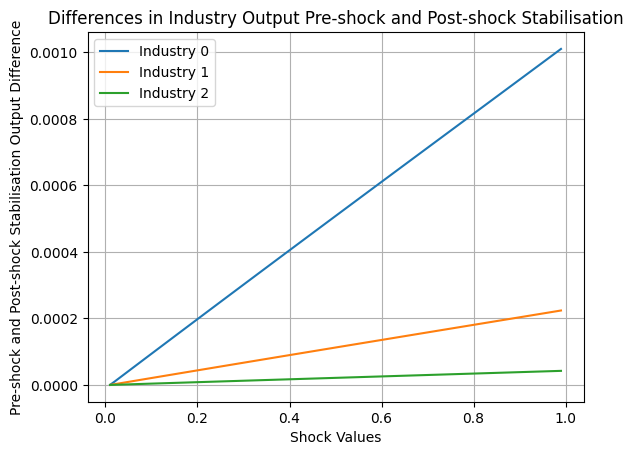

In [509]:
for industry in range(num_industries):
    stabilisation_output_differences = list({key: value[industry] for key, value in shock_pre_post_outputs_differences.items()}.values())
    plt.plot(shock_values, np.array(stabilisation_output_differences), label=f'Industry {industry}')

plt.xlabel('Shock Values')
plt.ylabel('Pre-shock and Post-shock Stabilisation Output Difference')
plt.title('Differences in Industry Output Pre-shock and Post-shock Stabilisation')
plt.legend()
plt.grid(True)
plt.show()



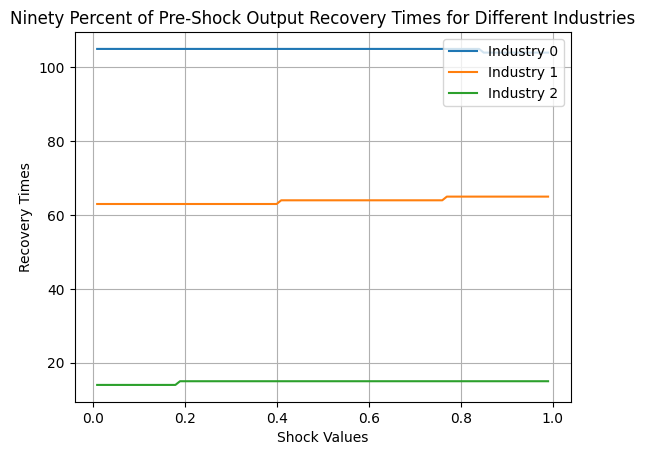

In [510]:
for industry in range(num_industries):
    recovery_times = list({key: value[industry] for key, value in shock_recoveries_ninety_percent.items()}.values())
    plt.plot(shock_values, np.array(recovery_times), label=f'Industry {industry}')

plt.xlabel('Shock Values')
plt.ylabel('Recovery Times')
plt.title('Ninety Percent of Pre-Shock Output Recovery Times for Different Industries')
plt.legend()
plt.grid(True)
plt.show()

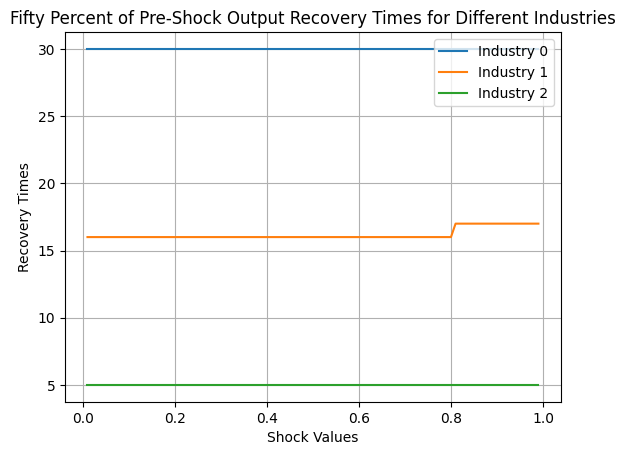

In [511]:
for industry in range(num_industries):
    recovery_times = list({key: value[industry] for key, value in shock_recoveries_fifty_percent.items()}.values())
    plt.plot(shock_values, np.array(recovery_times), label=f'Industry {industry}')

plt.xlabel('Shock Values')
plt.ylabel('Recovery Times')
plt.title('Fifty Percent of Pre-Shock Output Recovery Times for Different Industries')

plt.legend()
plt.grid(True)
plt.show()

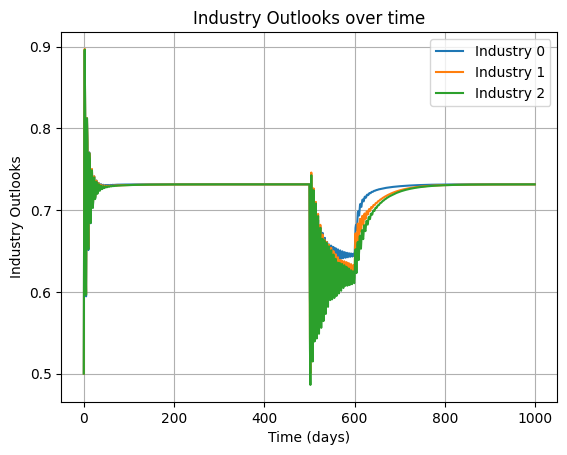

In [512]:
x = run_model(days=1000, shock_magnitude=0.9)   
time_axis = np.arange(start = 0, stop=1000, step=1)

for industry in range(num_industries):
    outlooks = list({key: value[industry] for key, value in industry_outlooks.items()}.values())
    plt.plot(time_axis, np.array(outlooks), label=f'Industry {industry}')
    
    
plt.xlabel('Time (days)')
plt.ylabel('Industry Outlooks')
plt.title('Industry Outlooks over time')
plt.legend()
plt.grid(True)
plt.show()



In [513]:
industry_outlooks

{0: array([0.5, 0.5, 0.5]),
 1: array([0.80748698, 0.80869067, 0.80817735]),
 2: array([0.89513768, 0.89719747, 0.89631588]),
 3: array([0.81000748, 0.81455947, 0.81257601]),
 4: array([0.64011324, 0.64676702, 0.64377336]),
 5: array([0.59451484, 0.59781707, 0.5961664 ]),
 6: array([0.72341152, 0.72266521, 0.7227366 ]),
 7: array([0.81251917, 0.81247628, 0.81221649]),
 8: array([0.78233665, 0.78527081, 0.78350946]),
 9: array([0.68948212, 0.6949229 , 0.6917035 ]),
 10: array([0.65114447, 0.65481886, 0.65227125]),
 11: array([0.71101201, 0.71095067, 0.71029159]),
 12: array([0.77066888, 0.77012981, 0.7697804 ]),
 13: array([0.76260421, 0.76428953, 0.76262624]),
 14: array([0.71119813, 0.71497213, 0.71185035]),
 15: array([0.68399464, 0.68696524, 0.68409659]),
 16: array([0.71196805, 0.71230296, 0.71103982]),
 17: array([0.74883721, 0.74831382, 0.74768056]),
 18: array([0.74951409, 0.75032478, 0.74876044]),
 19: array([0.72160753, 0.7239103 , 0.72110611]),
 20: array([0.70340188, 0.70541